In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetesDs = load_diabetes()
print(diabetesDs["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [3]:
# Save the input and target variables

print(diabetesDs.keys())
data = diabetesDs["data"]
targets = diabetesDs["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets-targets.mean(axis = 0)) / targets.std()


In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

trainData,testData,trainTargets,testTargets = train_test_split(data,targets,test_size = 0.1)
print(trainData.shape)

(397, 10)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getModel():
    model = Sequential()
    model.add(Dense(128,activation="relu",input_shape=(trainData.shape[1],)))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(129,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(129,activation="relu"))
    model.add(Dense(1))
    return model
    
model = getModel()

In [7]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 129)               16641     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16640     
_________________________________________________________________
dense_5 (Dense)              (None, 129)               16641     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(trainData,trainTargets,epochs=100,validation_split=0.15,batch_size=64)


Train on 337 samples, validate on 60 samples
Epoch 1/100
337/337 [==============================] - 2s 5ms/sample - loss: 1.0082 - mae: 0.8595 - val_loss: 0.7389 - val_mae: 0.7544
Epoch 2/100
337/337 [==============================] - 0s 560us/sample - loss: 0.9007 - mae: 0.8131 - val_loss: 0.5780 - val_mae: 0.6758
Epoch 3/100
337/337 [==============================] - 0s 585us/sample - loss: 0.6659 - mae: 0.6895 - val_loss: 0.4192 - val_mae: 0.5072
Epoch 4/100
337/337 [==============================] - 0s 597us/sample - loss: 0.5533 - mae: 0.5910 - val_loss: 0.4509 - val_mae: 0.5116
Epoch 5/100
337/337 [==============================] - 0s 590us/sample - loss: 0.5232 - mae: 0.5632 - val_loss: 0.5819 - val_mae: 0.6604
Epoch 6/100
337/337 [==============================] - 0s 351us/sample - loss: 0.5342 - mae: 0.6090 - val_loss: 0.4202 - val_mae: 0.5371
Epoch 7/100
337/337 [==============================] - 0s 854us/sample - loss: 0.4849 - mae: 0.5590 - val_loss: 0.4021 - val_mae: 0.532

In [10]:
# Evaluate the model on the test set
model.evaluate(testData,testTargets,verbose=2)


45/1 - 0s - loss: 1.0813 - mae: 0.8436


[1.057533081372579, 0.8435842]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

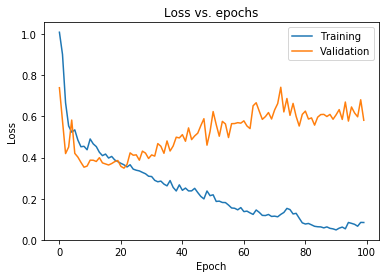

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128,kernel_regularizer = regularizers.l2(wd), activation="relu",input_shape=(trainData.shape[1],)),
        Dropout(rate),
        Dense(128,kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128,kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128,kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128,kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128,kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5,0.3)

In [16]:
# Compile the model

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

In [17]:
# Train the model, with some of the data reserved for validation
history = model.fit(trainData,trainTargets,epochs=100,validation_split=0.15,batch_size=64,verbose = False)


In [18]:
# Evaluate the model on the test set
model.evaluate(testData,testTargets,verbose=2)


45/1 - 0s - loss: 0.9217 - mae: 0.7759


[0.8692942765023973, 0.77591646]

#### Plot the learning curves

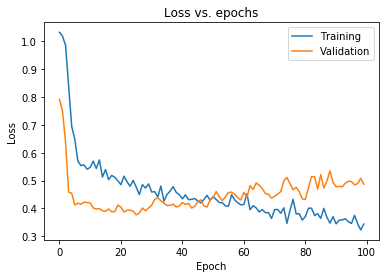

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback
 #training callback
class TrainingCallback(Callback):
    def on_train_begin(self,loss=None):
        print("Starting training...")
    def on_epoch_begin(self,epoch,logs=None):
        print(f"Starting epoch: {epoch}")
    def on_train_batch_begin(self,batch,logs=None):
        print(f"Training: Starting Batch: {batch}")
    def on_train_batch_end(self,batch,logs=None):
        print(f"Training: Finished batch {batch}")
    def on_epoch_end(self,epoch,logs=None):
        print(f"Finished epoch {epoch}")
    def on_train_end(self,logs=None):
        print(f"Finished Training")
        
# testing callback     
class TestingCallback(Callback):
    def on_test_begin(self,loss=None):
        print("Starting testing...")

    def on_test_batch_begin(self,batch,logs=None):
        print(f"Training: Starting testing  Batch: {batch}")
    def on_test_batch_end(self,batch,logs=None):
        print(f"Training: Finished testing batch {batch}")

    def on_test_end(self,logs=None):
        print(f"Finished Testing")        

#prediction callback
class PredictionCallback(Callback):
    def on_predict_begin(self,loss=None):
        print("Starting predict...")

    def on_predict_batch_begin(self,batch,logs=None):
        print(f"Training: Starting predict  Batch: {batch}")
    def on_predict_batch_end(self,batch,logs=None):
        print(f"Training: Finished predict batch {batch}")

    def on_predict_end(self,logs=None):
        print(f"Finished predict")      


In [21]:
# Re-build the model

model= get_regularised_model(1e-5,0.3)


In [22]:
# Compile the model
model.compile(optimizer="adam",loss="mse")


#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation
model.fit(trainData,trainTargets,epochs=3,batch_size=128,verbose=False,callbacks=[TrainingCallback()])


Starting training...
Starting epoch: 0
Training: Starting Batch: 0
Training: Finished batch 0
Training: Starting Batch: 1
Training: Finished batch 1
Training: Starting Batch: 2
Training: Finished batch 2
Training: Starting Batch: 3
Training: Finished batch 3
Finished epoch 0
Starting epoch: 1
Training: Starting Batch: 0
Training: Finished batch 0
Training: Starting Batch: 1
Training: Finished batch 1
Training: Starting Batch: 2
Training: Finished batch 2
Training: Starting Batch: 3
Training: Finished batch 3
Finished epoch 1
Starting epoch: 2
Training: Starting Batch: 0
Training: Finished batch 0
Training: Starting Batch: 1
Training: Finished batch 1
Training: Starting Batch: 2
Training: Finished batch 2
Training: Starting Batch: 3
Training: Finished batch 3
Finished epoch 2
Finished Training


In [24]:
# Evaluate the model
model.evaluate(testData,testTargets,verbose = False,callbacks=[TestingCallback()])


Starting testing...
Training: Starting testing  Batch: 0
Training: Finished testing batch 0
Training: Starting testing  Batch: 1
Training: Finished testing batch 1
Finished Testing


1.040414399570889

In [25]:
# Make predictions with the model
model.predict(testData,verbose=False,callbacks=[PredictionCallback()])


Starting predict...
Training: Starting predict  Batch: 0
Training: Finished predict batch 0
Training: Starting predict  Batch: 1
Training: Finished predict batch 1
Finished predict


array([[ 0.09521131],
       [ 0.06401473],
       [ 0.02968777],
       [ 0.00766681],
       [ 0.09062252],
       [ 0.10147962],
       [-0.00103687],
       [ 0.09566338],
       [ 0.04806421],
       [ 0.15411139],
       [ 0.09638031],
       [ 0.09936234],
       [ 0.10637639],
       [ 0.095876  ],
       [ 0.02764678],
       [ 0.10931498],
       [ 0.07324784],
       [ 0.07685434],
       [ 0.00326933],
       [ 0.02347339],
       [ 0.08399841],
       [ 0.14985289],
       [ 0.0416417 ],
       [-0.00131459],
       [ 0.01388258],
       [ 0.07526624],
       [-0.01262435],
       [-0.02027256],
       [ 0.07238942],
       [ 0.0793919 ],
       [ 0.04444543],
       [ 0.04734458],
       [ 0.08654363],
       [ 0.01988189],
       [ 0.09264347],
       [ 0.10707352],
       [ 0.14683592],
       [ 0.04094934],
       [ 0.14077769],
       [ 0.07247557],
       [ 0.07825959],
       [ 0.01769613],
       [ 0.00344806],
       [ 0.08783661],
       [-0.01341258]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [26]:
# Re-train the unregularised model
unregularizedModel = getModel()
unregularizedModel.compile(
    optimizer="adam",
    loss="mse"
)
unregHist = unregularizedModel.fit(
    trainData,
    trainTargets,
    epochs=100,
    validation_split=0.15,
    batch_size=64,verbose=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]
)


In [27]:
# Evaluate the model on the test set
unregularizedModel.evaluate(testData,testTargets,verbose=2)


45/1 - 0s - loss: 0.7802


0.7298515306578742

In [28]:
# Re-train the regularised model
regularizedModel = get_regularised_model(1e-8,0.2)
regularizedModel.compile(
    optimizer="adam",
    loss="mse"
)
regHist = regularizedModel.fit(
    trainData,
    trainTargets,
    epochs=100,
    validation_split=0.15,
    batch_size=64,verbose=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]
)



In [29]:
# Evaluate the model on the test set

regularizedModel.evaluate(testData,testTargets,verbose=2)

45/1 - 0s - loss: 0.8671


0.8235725641250611

#### Plot the learning curves

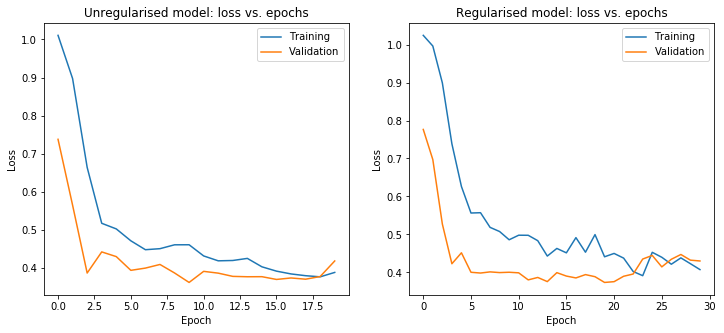

In [30]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unregHist.history['loss'])
plt.plot(unregHist.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(regHist.history['loss'])
plt.plot(regHist.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()